In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import data_cleaning as dc
from sklearn import metrics
%matplotlib inline

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload

In [5]:
df = pd.read_csv('data/products_new.csv')
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0','payment_value'], inplace=True)

In [6]:
df.columns

Index(['order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'review_id', 'review_score', 'customer_city',
       'customer_state', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

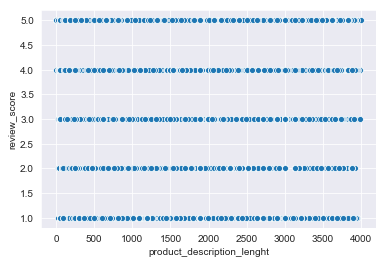

In [22]:
sns.scatterplot(x=df["product_description_lenght"], y=df["review_score"])

In [70]:
df=df.rename(columns={'review_score':'Review_Score', 'price':'Price_$','freight_value':"Shipping_Cost", 'product_name_lenght':"Product_Name_Length",
       'product_description_lenght':'Product_Description_Length', 'product_photos_qty':'Product_Photos_Qty', 'product_weight_g':'Product_Weight_g',
       'product_length_cm':'Product_Length_cm', 'product_height_cm':'Product_Height_cm', 'product_width_cm':'Product_Width_cm'})

In [71]:
cont_features = []

for colname, coltype in df.dtypes.iteritems():
    if coltype in [np.float64, np.int64]:
        cont_features.append(colname)
        
cont_df = pd.DataFrame(df, columns=cont_features)
len(cont_df.columns)

10

In [122]:
df.columns

Index(['order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'review_id', 'Review_Score', 'customer_city',
       'customer_state', 'Price_$', 'Shipping_Cost', 'Product_Name_Length',
       'Product_Description_Length', 'Product_Photos_Qty', 'Product_Weight_g',
       'Product_Length_cm', 'Product_Height_cm', 'Product_Width_cm',
       'product_category_name_english'],
      dtype='object')

In [74]:
cont_df=cont_df.rename(columns={'review_score':'Review_Score', 'price':'Price_$','freight_value':"Shipping_Cost", 'product_name_lenght':"Product_Name_Length",
       'product_description_lenght':'Product_Description_Length', 'product_photos_qty':'Product_Photos_Qty', 'product_weight_g':'Product_Weight_g',
       'product_length_cm':'Product_Length_cm', 'product_height_cm':'Product_Height_cm', 'product_width_cm':'Product_Width_cm'})

cont_df["Product_Area_cm2"]=cont_df['Product_Length_cm']*cont_df['Product_Width_cm']

cont_df["Product_Photos_Qty"].astype('int64')
cont_df["Product_Description_Length"].astype('int64')
cont_df["Product_Name_Length"].astype('int64')
cont_df["Review_Score"].astype('int64')


cont_df=cont_df.drop(columns=['Product_Length_cm','Product_Width_cm'])
cont_df.head()

KeyError: 'Product_Length_cm'

In [75]:
# Create X and y then split in train and test
features = [col for col in cont_df.columns if col != 'Price_$']
X = df.loc[:, features]
y = df.loc[:, 'Price_$']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

#Create X test and X train from continuous variables
X_train_cont = X_train.loc[:, features]

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [76]:
X_train_cont.drop(columns="Price_$",inplace=True)

KeyError: "['Price_$'] not found in axis"

In [77]:
X_train_cont.columns

Index(['Review_Score', 'Shipping_Cost', 'Product_Name_Length',
       'Product_Description_Length', 'Product_Photos_Qty', 'Product_Weight_g',
       'Product_Height_cm', 'Product_Area_cm2'],
      dtype='object')

In [78]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer

# Impute missing values with median using Imputer from sklearn.preprocessing
impute = Imputer(strategy='median')
impute.fit(X_train_cont)

X_train_imputed = impute.transform(X_train_cont)

# Fit the model and print R2 and MSE for train and test
linreg = LinearRegression()
linreg.fit(X_train_imputed, y_train)

print('Training r^2:', linreg.score(X_train_imputed, y_train))
print('Training MSE:', mean_squared_error(y_train, linreg.predict(X_train_imputed)))

Training r^2: 0.21036082719792507
Training MSE: 26440.722923505768


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [79]:
from sklearn.preprocessing import StandardScaler

# Scale the train and test data
ss = StandardScaler()
ss.fit(X_train_imputed)

X_train_imputed_scaled = ss.transform(X_train_imputed)

In [80]:
linreg_norm = LinearRegression()
linreg_norm.fit(X_train_imputed_scaled, y_train)

print('Training r^2:', linreg_norm.score(X_train_imputed_scaled, y_train))
print('Training MSE:', mean_squared_error(y_train, linreg_norm.predict(X_train_imputed_scaled)))

Training r^2: 0.21036082719792515
Training MSE: 26440.72292350576


In [81]:
linreg_norm.coef_
# X_train_cont.columns

array([ 2.89790746, 57.96143917, -1.61059803, 29.08949142,  5.07317947,
       23.06985533,  2.74482608])

In [82]:
plt.figure(figsize=(20,8))
sns.barplot(x=X.columns, y=linreg_norm.coef_)

ValueError: Grouper and axis must be same length

<Figure size 1440x576 with 0 Axes>

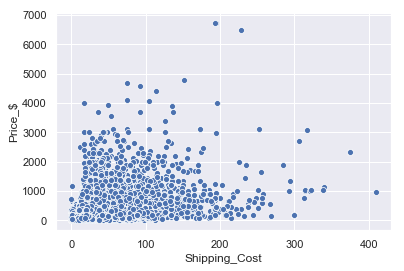

In [87]:
sns.scatterplot(data=cont_df,x="Shipping_Cost",y="Price_$")

In [ ]:
sns.scatterplot(data=cont_df,x="Product_Area_cm2",y="Price_$")

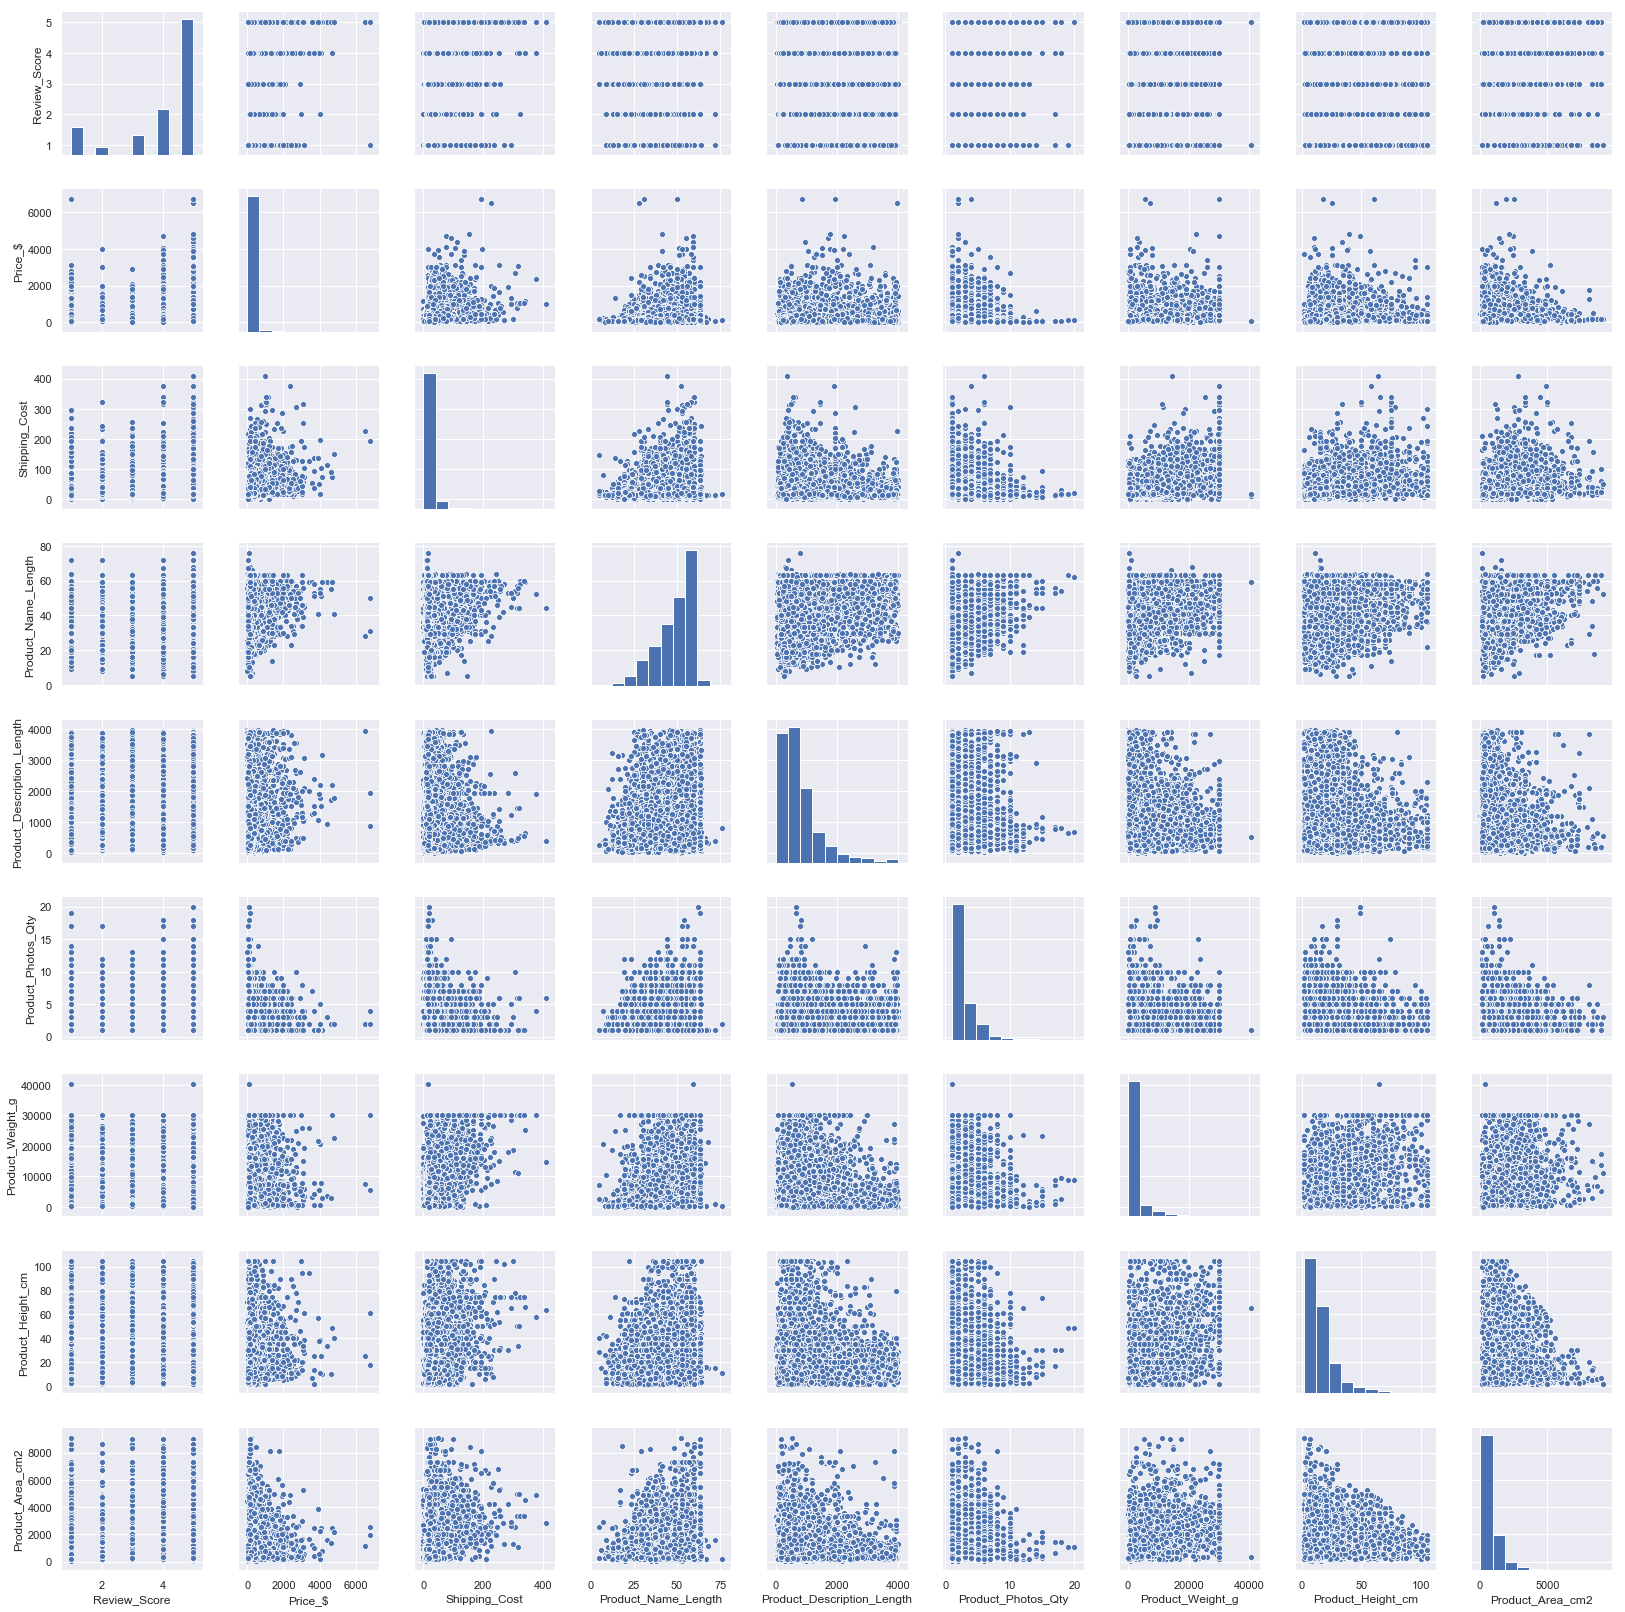

In [88]:
sns.pairplot(cont_df)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


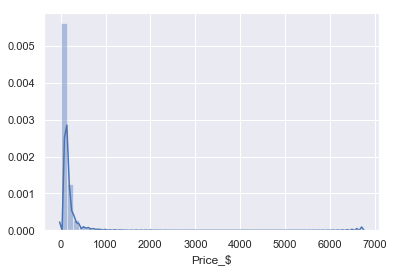

In [90]:
sns.distplot(cont_df["Price_$"])

In [93]:
X.columns

Index(['Review_Score', 'Shipping_Cost', 'Product_Name_Length',
       'Product_Description_Length', 'Product_Photos_Qty', 'Product_Weight_g',
       'Product_Height_cm', 'Product_Area_cm2'],
      dtype='object')

In [111]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [116]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(linreg, X_train_imputed_scaled, y_train, cv=15, scoring='r2')
cv_5_results

array([0.19974174, 0.22484195, 0.24092987, 0.19241056, 0.18649287,
       0.22110956, 0.19766375, 0.19375771, 0.18056411, 0.20427677,
       0.22141469, 0.20828513, 0.23838734, 0.19392363, 0.23756703])

In [104]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'continuous'

In [53]:
alphas = [1,2,3]

from sklearn.linear_model import Ridge

def ridge(list):
    for x in list:
        # Train model setting alpha (lambda) to 0.05
        ridge = Ridge(alpha=x, normalize=True)
        #Fit Ridge model to training data
        ridge.fit(X_train_imputed_scaled, y_train)
        y_predict_ridge = ridge.predict(X_train_imputed_scaled)
        # Calculate R^2 and mse
        print('Training r^2:',ridge.score(X_train_imputed_scaled, y_train))
        print('Training MSE:',mean_squared_error(y_train,y_predict_ridge))
        
ridge(alphas)

Training r^2: 0.1779220055173566
Training MSE: 27526.922703814675
Training r^2: 0.1467277945713168
Training MSE: 28571.447237108525
Training r^2: 0.12389473260067173
Training MSE: 29336.002347664555


In [54]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.05, normalize=True)
lasso.fit(X_train_imputed_scaled, y_train)
y_predict_lasso = lasso.predict(X_train_imputed_scaled)
# calculating mse
print('Training MSE:',mean_squared_error(y_train,y_predict_lasso))
print('Training r^2:',lasso.score(X_train_imputed_scaled, y_train))

Training MSE: 26921.587150834155
Training r^2: 0.1960000537880522


In [55]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.05, l1_ratio=0.5, normalize=False)
elastic.fit(X_train_imputed_scaled,y_train)
y_predict_elastic = elastic.predict(X_train_imputed_scaled)
#calculating mse
print('Training MSE:', mean_squared_error(y_train, y_predict_elastic))
print('Training r^2:', elastic.score(X_train_imputed_scaled,y_train))

Training MSE: 26443.459824277157
Training r^2: 0.2102790910038197


In [43]:
X.columns

Index(['Review_Score', 'Shipping_Cost', 'Product_Name_Length',
       'Product_Description_Length', 'Product_Photos_Qty', 'Product_Weight_g',
       'Product_Height_cm', 'Area'],
      dtype='object')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 114062 and the array at index 1 has size 85546

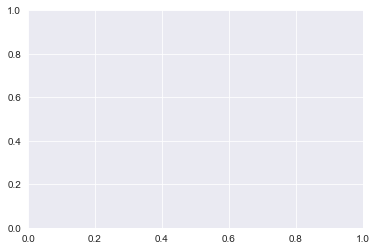

In [58]:
slope = elastic.coef_
intercept = elastic.intercept_

fig, ax = plt.subplots()
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8, 8)})
ax = sns.regplot(x=X, y=y_predict_elastic, line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)});

ax.legend()

sns.regplot(x=X, y=y_predict_elastic, fit_reg=False, ax=ax);
sns.regplot(x=X, y=y_predict_elastic,scatter=False, ax=ax);

In [ ]:
sns.scatterplot(x=cont_df.Shipping_Cost, y=cont_df.customer_city)

In [59]:
elastic.get_params

<bound method BaseEstimator.get_params of ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)>